In [1]:
import numpy as np
from brian2 import *
from brian2modelfitting import *

dt = 0.01 * ms
defaultclock.dt = dt

# Generate a step-current input and an "experimental" voltage trace
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*5, np.zeros(int(5*ms/dt))])* 5 *nA
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*10, np.zeros(int(5*ms/dt))]) * 5 * nA

input_current2 = np.stack((input_current0, input_current1))
I = TimedArray(input_current0, dt=dt)

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


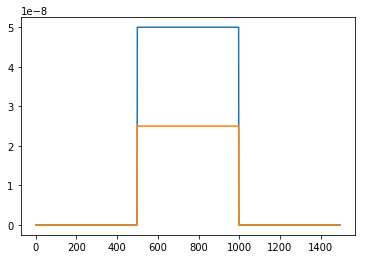

In [12]:
plt.plot(input_current2.transpose());

In [2]:
# C = 1*nF
# gL = 30*nS
EL = -70*mV
VT = -50*mV
DeltaT = 2*mV
eqs = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I(t))/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''')

group = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group.v = -70 *mV
group.set_states({'gL': [30*nS], 'C':[1*nF]})

monitor0 = StateMonitor(group, 'v', record=True)
smonitor0  = SpikeMonitor(group)

run(60*ms)

In [3]:
voltage0 = monitor0.v[0]/mV
out_spikes0 = getattr(smonitor0, 't') / ms

start_scope()
I = TimedArray(input_current1, dt=dt)
group1 = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group1.v = -70 *mV
group1.set_states({'gL': [30*nS], 'C':[1*nF]})

monitor1 = StateMonitor(group1, 'v', record=True)
smonitor1  = SpikeMonitor(group1)
run(60*ms)

out_spikes1 = getattr(smonitor1, 't') / ms
voltage1 = monitor1.v[0]/mV


inp_trace0 = np.array([input_current0])
inp_trace1 = np.array([input_current1])

inp_trace = np.concatenate((inp_trace0, inp_trace1))
out_spikes = np.array([out_spikes0, out_spikes1])
print('out_spikes', out_spikes)

out_spikes [array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ])
 array([5.79, 6.6 , 7.41, 8.22, 9.03, 9.84])]


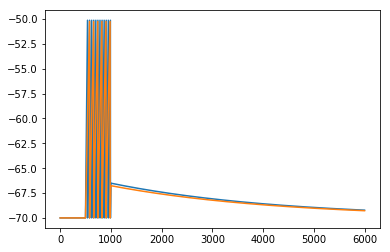

In [13]:
plt.plot(voltage0)
plt.plot(voltage1)

In [4]:
# FIT SPIKES
start_scope()
EL = -70*mV
VT = -50*mV
DeltaT = 2*mV

eqs_fit = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I)/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''',
    # EL = -70*mV,
    # VT = -50*mV,
    # DeltaT = 2*mV,
    # C=1*nF
    )

n_opt = NevergradOptimizer('DE')
metric = GammaFactor(dt, 60*ms)

In [5]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs_fit, input_var='I', dt=dt,
                     input=inp_trace * amp, output=out_spikes,
                     n_samples=30,
                     threshold='v > -50*mV',
                     reset='v = -70*mV',
                     param_init={'v': -70*mV},
                     method='exponential_euler',)
result_dict, error = fitter.fit(n_rounds=2,
                                optimizer=n_opt,
                                metric=metric,
                                callback='progressbar',
                                gL=[20*nS, 40*nS],
                                C = [0.5*nF, 1.5*nF])



# print(result_dict, error)
print('goal:', {'gL': [30*nS], 'C':[1*nF]})
print('results:', result_dict['C']*farad, result_dict['gL']*siemens)

res = {'gL': [result_dict['gL']*siemens], 'C': [result_dict['C']*farad]}


goal: {'gL': [30. * nsiemens], 'C': [1. * nfarad]}
results: 1.00231007 nF 23.93692514 nS


In [6]:
# visualization of the results
start_scope()

EL = -70*mV
VT = -50*mV
DeltaT = 2*mV
spikes = fitter.generate_spikes(params=None, param_init={'v': -70*mV})
print('spike times:', spikes)

spike times: [array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ]), array([5.79, 6.6 , 7.41, 8.22, 9.03, 9.84])]


In [7]:
start_scope()
EL = -70*mV
VT = -50*mV
DeltaT = 2*mV
fits = fitter.generate(params=None,
                       output_var='v',
                       param_init={'v': -70*mV})


print('fits', fits)

fits [[-70.         -69.99999998 -69.99999996 ... -66.90067805 -66.90141803
  -66.90215784]
 [-70.         -69.99999998 -69.99999996 ... -67.12412034 -67.12480698
  -67.12549345]] mV


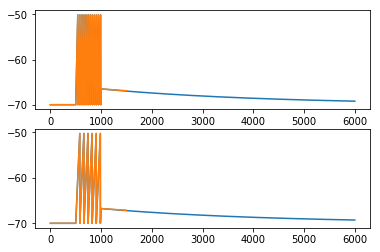

In [8]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(voltage0);
ax[0].plot(fits[0]/mV);
ax[1].plot(voltage1);
ax[1].plot(fits[1]/mV);
plt.show()